In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import gensim.downloader as api

# Load Gensim word embeddings
word_vectors = api.load("glove-wiki-gigaword-100")  # Load GloVe embeddings (100 dimensions)


[==================================================] 100.0% 128.1/128.1MB downloaded


In [2]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1762383.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65012.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1262871.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4096007.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
import torch
import torch.nn as nn

# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self, latent_size):
        super(ImageEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),  # Input: flattened image (28x28)
            nn.ELU(),
            nn.Linear(400, 200),
            nn.ELU(),
        )
        self.fc_mu = nn.Linear(200, latent_size)       # Mean for latent space
        self.fc_logvar = nn.Linear(200, latent_size)   # Log variance for latent space

    def forward(self, x):
        h1 = self.encoder(x)               # Hidden representation
        mu = self.fc_mu(h1)                # Mean of latent space
        logvar = self.fc_logvar(h1)        # Log variance of latent space
        return mu, logvar

# Image Decoder
class ImageDecoder(nn.Module):
    def __init__(self, latent_size):
        super(ImageDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),   # Input: latent space
            nn.ELU(),
            nn.Linear(200, 400),
            nn.ELU(),
            nn.Linear(400, 28 * 28),       # Output: flattened 28x28 image
            nn.Sigmoid(),                  # Output range between 0 and 1
        )

    def forward(self, z):
        return self.decoder(z)             # Decode latent vector to reconstruct image


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Initialize the codebook (embedding table)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # Flatten the input for easier processing
        flat_inputs = inputs.view(-1, self.embedding_dim)

        # Compute the distances between inputs and codebook vectors
        distances = torch.sum(flat_inputs**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(flat_inputs, self.embedding.weight.t())

        # Get the indices of the closest codebook vectors
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantize the inputs using the codebook
        quantized = self.embedding(encoding_indices).view_as(inputs)

        # Compute the VQ-VAE loss
        commitment_loss = self.commitment_cost * F.mse_loss(quantized.detach(), inputs)
        quantization_loss = F.mse_loss(quantized, inputs.detach())

        # Add the straight-through gradient estimator
        quantized = inputs + (quantized - inputs).detach()

        return quantized, quantization_loss, commitment_loss


In [5]:
class SemanticEncoderVQVAE(nn.Module):
    def __init__(self, latent_size, num_embeddings, embedding_dim):
        super(SemanticEncoderVQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Linear(200, latent_size),  # Ensure this matches latent_size
        )
        self.vq_layer = VectorQuantizer(num_embeddings, latent_size)  # Update to match latent_size

        # Adding mu and logvar layers like in the ImageEncoder
        self.fc_mu = nn.Linear(latent_size, latent_size)
        self.fc_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, c):
        z_e = self.encoder(c)  # Continuous latent encoding
        z_q, quantization_loss, commitment_loss = self.vq_layer(z_e)  # Quantized latent vector

        # Add these lines to calculate mu and logvar for the semantic latent space
        mu_c = self.fc_mu(z_e)
        logvar_c = self.fc_logvar(z_e)

        return mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss


In [6]:
# Semantic Decoder (same as before)
class SemanticDecoder(nn.Module):
    def __init__(self, latent_size):
        super(SemanticDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),
            nn.ELU(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.decoder(z)

In [7]:
class CADA_VAE(nn.Module):
    def __init__(self, latent_size, num_embeddings, embedding_dim):
        super(CADA_VAE, self).__init__()

        # Image encoder and decoder
        self.image_encoder = ImageEncoder(latent_size)
        self.image_decoder = ImageDecoder(latent_size)

        # Semantic encoder and decoder with VQ-VAE
        self.semantic_encoder = SemanticEncoderVQVAE(latent_size, num_embeddings, embedding_dim)
        self.semantic_decoder = SemanticDecoder(latent_size)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from latent space using mu and logvar."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        # Image VAE (continuous latent space)
        mu_x, logvar_x = self.image_encoder(x)
        z_x = self.reparameterize(mu_x, logvar_x)
        recon_x = self.image_decoder(z_x)

        # Semantic VQ-VAE (discrete latent space)
        mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss = self.semantic_encoder(c)

        # Ensure `z_q` shape matches input to decoder
        recon_c = self.semantic_decoder(z_q)

        return recon_x, recon_c, mu_x, logvar_x, mu_c, logvar_c, z_e, quantization_loss, commitment_loss




In [8]:

# Define the loss functions
def vae_loss(recon, target, mu, logvar, beta=1.0):
    # Print shapes for debugging
    print(f"Recon shape: {recon.shape}, Target shape: {target.shape}")

    # Ensure the target is reshaped correctly based on its actual size
    recon_loss = F.binary_cross_entropy(recon.view(-1, 28*28), target.view(-1, 28*28), reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss

def cada_vae_loss(recon_x_from_x, x, recon_c_from_c, c, recon_x_from_c, recon_c_from_x,
                  mu_x, logvar_x, z_e, quantization_loss, commitment_loss, beta, gamma, delta):
    # Image VAE Loss
    loss_x = vae_loss(recon_x_from_x, x, mu_x, logvar_x, beta)

    # Semantic reconstruction loss
    loss_c = F.mse_loss(recon_c_from_c, c)  # Use MSE loss for semantic embeddings

    # Cross-alignment loss (cross-reconstruction)
    ca_loss = F.mse_loss(recon_x_from_c, x) + F.mse_loss(recon_c_from_x, c)

    # Distribution alignment loss (Wasserstein distance)
    da_loss = torch.norm(mu_x - z_e) ** 2  # Simplified Wasserstein distance

    # Add VQ-VAE specific losses
    vq_vae_loss = quantization_loss + commitment_loss

    return loss_x + gamma * ca_loss + delta * da_loss + vq_vae_loss



# Define a mapping from numeric digits to words
digit_to_word = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

def get_semantic_embedding(labels,word_vectors):
    # Convert tensor labels to their word equivalents and fetch embeddings
    return torch.stack([torch.tensor(word_vectors[digit_to_word[int(label.item())]]) for label in labels], dim=0)

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_size = 20
num_embeddings = 512  # Example: size of the VQ-VAE codebook
embedding_dim = 100  # Example: dimensionality of the latent embeddings

# Initialize the CADA_VAE model
model = CADA_VAE(latent_size, num_embeddings, embedding_dim).to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

def train(epoch, model, train_loader, optimizer, beta=1.0, gamma=1.0, delta=1.0):
    model.train()
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # Get semantic embeddings
        embeddings = get_semantic_embedding(labels,word_vectors).to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_x_from_x, recon_c_from_c, mu_x, logvar_x, mu_c, logvar_c, z_e, quantization_loss, commitment_loss = model(data, embeddings)

        # Cross-reconstruction from the other modality
        recon_x_from_c = model.image_decoder(model.reparameterize(mu_c, logvar_c))  # Use image decoder
        recon_c_from_x = model.semantic_decoder(z_e)  # Use the quantized embedding directly

        # Calculate the total CADA-VAE loss
        loss = cada_vae_loss(recon_x_from_x, data.view(-1, 28*28), recon_c_from_c, embeddings,
                             recon_x_from_c, recon_c_from_x, mu_x, logvar_x, z_e,
                             quantization_loss, commitment_loss, beta, gamma, delta)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item()}")


# Train the model
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, beta=1.0, gamma=1.0, delta=1.0)

Streaming output truncated to the last 5000 lines.
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 7009.5087890625
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 7360.29833984375
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 6813.7119140625
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 6876.9287109375
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 6680.302734375
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 7133.078125
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 6768.49609375
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 7092.138671875
Recon shape: torch.Size([64, 784]), Target shape: torch.Size([64, 784])
Epoch [8/10] Loss: 6964.3813

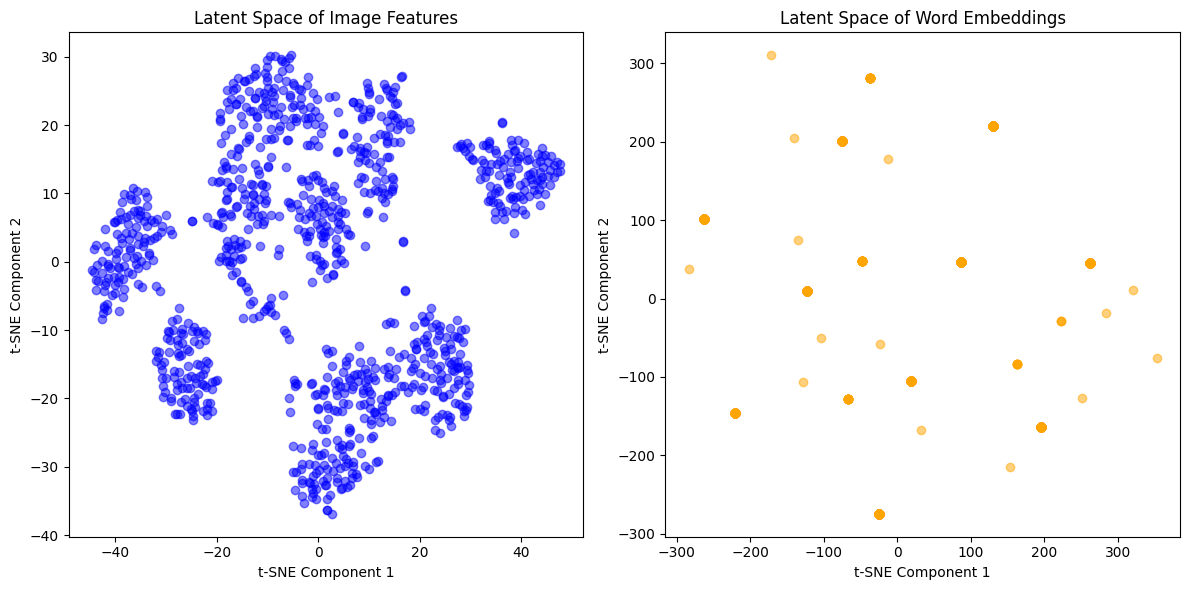

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a mapping from numeric digits to words
digit_to_word = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

def get_semantic_embedding(labels,word_vectors):
    # Convert tensor labels to their word equivalents and fetch embeddings
    return torch.stack([torch.tensor(word_vectors[digit_to_word[int(label.item())]]) for label in labels], dim=0)

def visualize_latent_space(model, data_loader, word_vectors, n_samples=1000):
    model.eval()  # Set model to evaluation mode
    latent_vectors_x = []
    latent_vectors_c = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data = data.to(device)
            # Get semantic embeddings
            embeddings_batch = get_semantic_embedding(labels, word_vectors).to(device)

            # Forward pass through the model to get latent representations
            mu_x, logvar_x = model.image_encoder(data.view(-1, 28 * 28))  # Image latent representations
            mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss = model.semantic_encoder(embeddings_batch)  # Semantic latent representations

            latent_vectors_x.append(mu_x.cpu().numpy())
            latent_vectors_c.append(mu_c.cpu().numpy())

            if len(latent_vectors_x) * data.size(0) >= n_samples:
                break  # Limit to n_samples

    latent_vectors_x = np.concatenate(latent_vectors_x, axis=0)[:n_samples]
    latent_vectors_c = np.concatenate(latent_vectors_c, axis=0)[:n_samples]

    # Reduce dimensions for visualization using t-SNE
    tsne_x = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors_x)
    tsne_c = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors_c)

    # Create scatter plots
    plt.figure(figsize=(12, 6))

    # Plot latent space for image features
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_x[:, 0], tsne_x[:, 1], c='blue', alpha=0.5)
    plt.title('Latent Space of Image Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    # Plot latent space for word embeddings
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_c[:, 0], tsne_c[:, 1], c='orange', alpha=0.5)
    plt.title('Latent Space of Word Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    plt.tight_layout()
    plt.show()


# After training the model
visualize_latent_space(model, train_loader, word_vectors)


In [10]:
import matplotlib.pyplot as plt

# Define a mapping from numeric digits to words
digit_to_word = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

def generate_images_from_semantic_embeddings(model, word_vectors, device):
    model.eval()  # Set the model to evaluation mode

    generated_images = []
    digits = [digit_to_word[i] for i in range(10)]  # Word forms of digits 0-9

    for digit in digits:
        # Get the semantic embedding for the digit
        embedding = word_vectors[digit]

        # Convert embedding to tensor and move to device
        embedding_tensor = torch.tensor(embedding).unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            # Forward pass through the semantic encoder
            mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss = model.semantic_encoder(embedding_tensor)

            # Reparameterize the latent space using mu_c and logvar_c (if needed)
            latent_c = model.reparameterize(mu_c, logvar_c)

            # Decode the latent representation to generate the image
            generated_image = model.image_decoder(latent_c)

        # Reshape and store the generated image
        generated_images.append(generated_image.view(28, 28).cpu().numpy())

    return generated_images


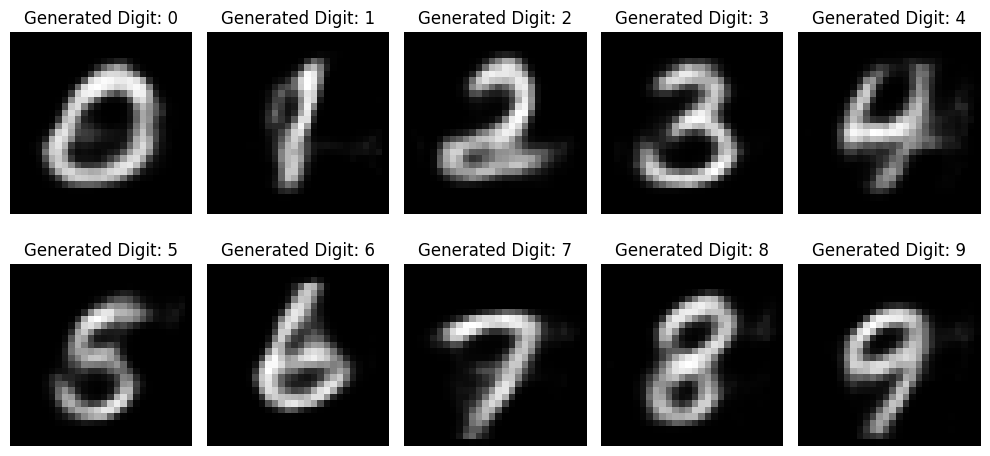

In [11]:
# Function to plot the generated images
def plot_generated_images(generated_images):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(f'Generated Digit: {i}')
        ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()

# Generate images using semantic embeddings
generated_images = generate_images_from_semantic_embeddings(model, word_vectors, device)

# Plot the generated images
plot_generated_images(generated_images)


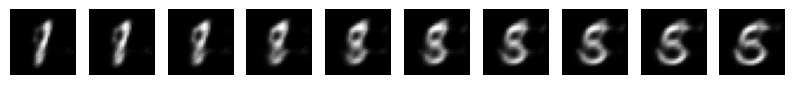

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def interpolate_between_digits(model, word_vectors, word1, word2, device, steps=10):
    """
    Interpolates between two digits using their semantic embeddings and visualizes the interpolated images.

    Args:
        model: The trained CADA-VAE model.
        word_vectors: GloVe word vectors.
        word1: The first word (e.g., "one").
        word2: The second word (e.g., "four").
        device: The device to run the model on (e.g., "cuda" or "cpu").
        steps: Number of interpolation steps (default is 10).
    """
    model.eval()  # Set the model to evaluation mode

    # Get the semantic embeddings for the two words
    embedding1 = torch.tensor(word_vectors[word1]).unsqueeze(0).to(device)
    embedding2 = torch.tensor(word_vectors[word2]).unsqueeze(0).to(device)

    with torch.no_grad():
        # Get the latent representations for both words
        mu_c1, _ = model.semantic_encoder(embedding1)[:2]  # Ignore the unnecessary returns
        mu_c2, _ = model.semantic_encoder(embedding2)[:2]

        # Linearly interpolate between the two latent vectors
        interpolation_factors = np.linspace(0, 1, steps)
        interpolated_latent_vectors = [(1 - alpha) * mu_c1 + alpha * mu_c2 for alpha in interpolation_factors]

        # Decode each interpolated latent vector to generate images
        interpolated_images = [model.image_decoder(latent_vector).view(28, 28).cpu().numpy()
                               for latent_vector in interpolated_latent_vectors]

    # Plot the interpolated images
    fig, axes = plt.subplots(1, steps, figsize=(steps, 2))
    for i, ax in enumerate(axes):
        ax.imshow(interpolated_images[i], cmap='gray')
        ax.axis('off')  # Turn off the axis labels

    plt.show()

# Example usage
interpolate_between_digits(model, word_vectors, 'one', 'five', device)
